# Takahashi Diffusion Example Usage

This notebook demonstrates how to use Takahashi Diffusion to generate synthetic time series data.

## Steps:
1. Generate mock stochastic exponential time series data (Geometric Brownian Motion)
2. Preprocess data using preprocessing utilities (convert to log returns)
3. Train Takahashi Diffusion model (assumes data is already log returns)
4. Generate synthetic samples

**Note:** Takahashi Diffusion uses wavelet transforms and diffusion models (DDPM) for generation.


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

project_root = Path().resolve().parents[0].parents[0]
sys.path.append(str(project_root))

from src.models.non_parametric.takahashi import TakahashiDiffusion
from src.utils.preprocessing_utils import (
    LogReturnTransformation,
    preprocess_non_parametric,
    create_dataloaders
)


## Step 1: Generate Mock Stochastic Exponential Time Series Data

We'll generate a Geometric Brownian Motion (GBM) time series, which is commonly used for modeling stock prices.


Generated 10001 days of price data
Price range: [95.85, 4534.70]


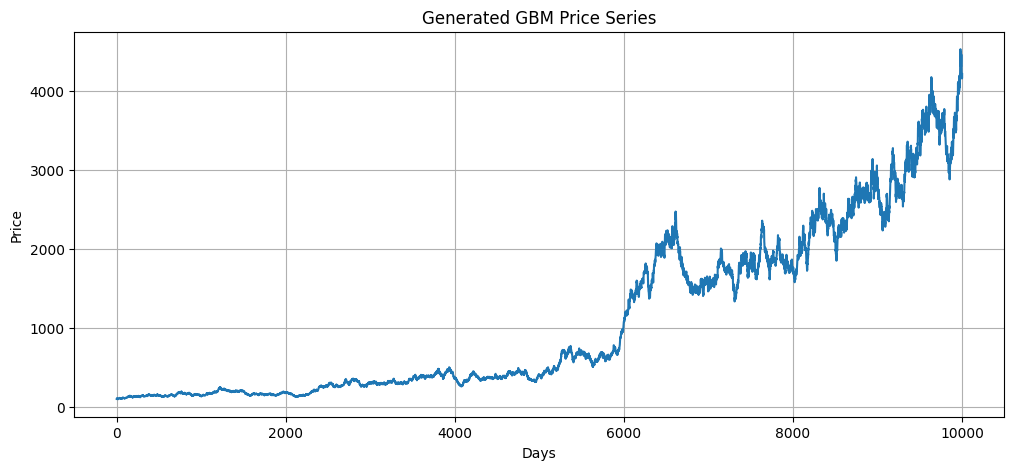

In [4]:
def generate_gbm_prices(
    initial_price: float = 100.0,
    mu: float = 0.05,  # Annual drift
    sigma: float = 0.2,  # Annual volatility
    num_days: int = 1000,
    dt: float = 1/252,  # Daily time step (252 trading days per year)
    seed: int = 42
) -> torch.Tensor:
    """
    Generate Geometric Brownian Motion price series.
    
    Args:
        initial_price: Starting price
        mu: Annual drift rate
        sigma: Annual volatility
        num_days: Number of days to simulate
        dt: Time step (default: daily)
        seed: Random seed
    
    Returns:
        Price series as torch.Tensor
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Generate random shocks
    Z = torch.randn(num_days)
    
    # GBM: dS = mu*S*dt + sigma*S*dW
    # In log space: d(log S) = (mu - 0.5*sigma^2)*dt + sigma*dW
    log_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    
    # Convert log returns to prices
    log_prices = torch.cumsum(torch.cat([torch.tensor([np.log(initial_price)]), log_returns]), dim=0)
    prices = torch.exp(log_prices)
    
    return prices

# Generate synthetic price data
original_prices = generate_gbm_prices(
    initial_price=100.0,
    mu=0.1,  # 10% annual return
    sigma=0.25,  # 25% annual volatility
    num_days=10000,
    seed=42
)

print(f"Generated {len(original_prices)} days of price data")
print(f"Price range: [{original_prices.min():.2f}, {original_prices.max():.2f}]")

# Visualize the generated data
plt.figure(figsize=(12, 5))
plt.plot(original_prices.numpy())
plt.title('Generated GBM Price Series')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True)
plt.show()


## Step 2: Preprocess Data

Convert prices to log returns and create sliding windows for non-parametric models.

**Note:** Takahashi Diffusion assumes input data is already log returns, so we convert prices to log returns here.


Log returns shape: torch.Size([10000])
Log returns stats: mean=0.000374, std=0.015819

Preprocessed data shapes:
Train: torch.Size([7920, 100])
Valid: torch.Size([990, 100])
Test: torch.Size([991, 100])


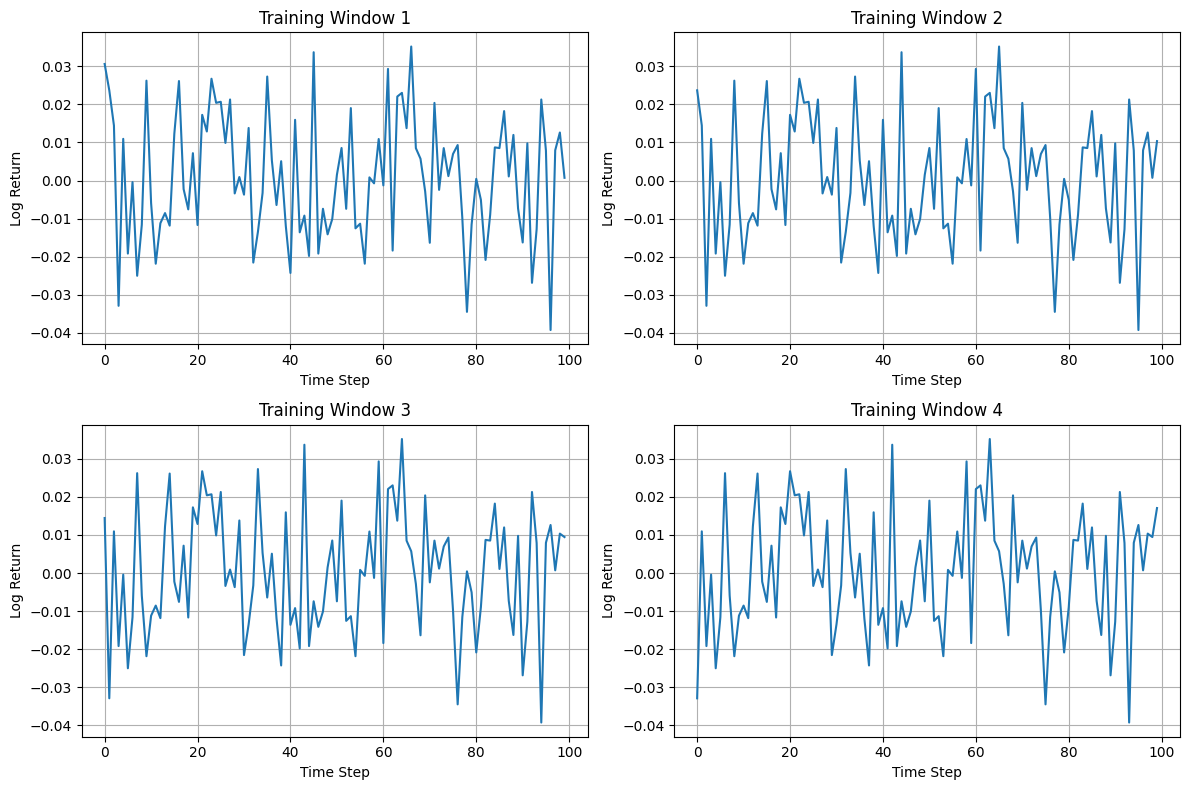

In [5]:
# Convert prices to log returns
scaler = LogReturnTransformation()
log_returns, initial_value = scaler.transform(original_prices)

print(f"Log returns shape: {log_returns.shape}")
print(f"Log returns stats: mean={log_returns.mean():.6f}, std={log_returns.std():.6f}")

# Preprocess for non-parametric model
seq_length = 100  # Window size for time series
train_data, valid_data, test_data, train_initial, valid_initial, test_initial = preprocess_non_parametric(
    ori_data=log_returns,
    original_prices=original_prices,
    seq_length=seq_length,
    valid_ratio=0.1,
    test_ratio=0.1,
    stride=1
)

print(f"\nPreprocessed data shapes:")
print(f"Train: {train_data.shape}")
print(f"Valid: {valid_data.shape}")
print(f"Test: {test_data.shape}")

# Visualize a few training windows
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i in range(4):
    axes[i].plot(train_data[i].numpy())
    axes[i].set_title(f'Training Window {i+1}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Log Return')
    axes[i].grid(True)
plt.tight_layout()
plt.show()


## Step 3: Create DataLoaders

Create PyTorch DataLoaders for training.


In [6]:
# Create DataLoaders
batch_size = 64
train_loader, valid_loader, test_loader = create_dataloaders(
    train_data=train_data,
    valid_data=valid_data,
    test_data=test_data,
    batch_size=batch_size,
    train_initial=train_initial,
    valid_initial=valid_initial,
    test_initial=test_initial,
    num_workers=0,
    pin_memory=False
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Check batch shape
sample_batch, sample_initial = next(iter(train_loader))
print(f"\nBatch shape: {sample_batch.shape}")
print(f"Initial values shape: {sample_initial.shape}")


Number of training batches: 124
Number of validation batches: 16
Number of test batches: 16

Batch shape: torch.Size([64, 100])
Initial values shape: torch.Size([64])


## Step 4: Initialize and Train Takahashi Diffusion

Create Takahashi Diffusion model and train it on the preprocessed data.

**Note:** Takahashi Diffusion uses wavelet transforms and diffusion models (DDPM) for generation. It assumes input data is already log returns.


In [7]:
# Initialize Takahashi Diffusion model
model = TakahashiDiffusion(
    length=seq_length,
    num_channels=1,
    num_steps=200,
    beta_start=0.0001,
    beta_end=0.02,
    wavelet='haar',
    power_transform=1.0,
    winsorize_threshold=3.0,
    lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(f"Takahashi Diffusion model initialized on device: {model.device}")
print(f"Model parameters:")
print(f"  - Sequence length: {model.length}")
print(f"  - Number of channels: {model.num_channels}")
print(f"  - Number of diffusion steps: {model.num_steps}")
print(f"  - Wavelet: {model.wavelet}")


Takahashi Diffusion model initialized on device: cpu
Model parameters:
  - Sequence length: 100
  - Number of channels: 1
  - Number of diffusion steps: 200
  - Wavelet: haar


In [8]:
# Train the model
print("Starting Takahashi Diffusion training...")
print("Note: Takahashi Diffusion uses DDPM (Denoising Diffusion Probabilistic Model) with wavelet transforms.")
print("This may take a while - be patient!")
model.fit(
    data_loader=train_loader,
    num_epochs=1  # Can increase for better results
)
print("\nTraining complete!")


Starting Takahashi Diffusion training...
Note: Takahashi Diffusion uses DDPM (Denoising Diffusion Probabilistic Model) with wavelet transforms.
This may take a while - be patient!
TakahashiDiffusion UNet trainable parameters: 15,722,625
Image dimensions: 8 x 128
TakahashiDiffusion epoch 1/1, Loss: 0.290067

Training complete!


## Step 5: Generate Synthetic Samples

Generate synthetic time series samples using the trained model.


In [9]:
# Generate synthetic samples
num_samples = 100
generation_length = seq_length

print(f"Generating {num_samples} synthetic samples of length {generation_length}...")
generated_samples = model.generate(
    num_samples=num_samples,
    generation_length=generation_length,
    seed=123
)

print(f"Generated samples shape: {generated_samples.shape}")
print(f"Generated samples stats: mean={generated_samples.mean():.6f}, std={generated_samples.std():.6f}")

# Compare with real data
print(f"\nReal data stats: mean={train_data.mean():.6f}, std={train_data.std():.6f}")


Generating 100 synthetic samples of length 100...
Generated samples shape: torch.Size([100, 100])
Generated samples stats: mean=-0.000685, std=0.008700

Real data stats: mean=0.000354, std=0.015761


## Step 6: Visualize Results

Compare generated samples with real training data.


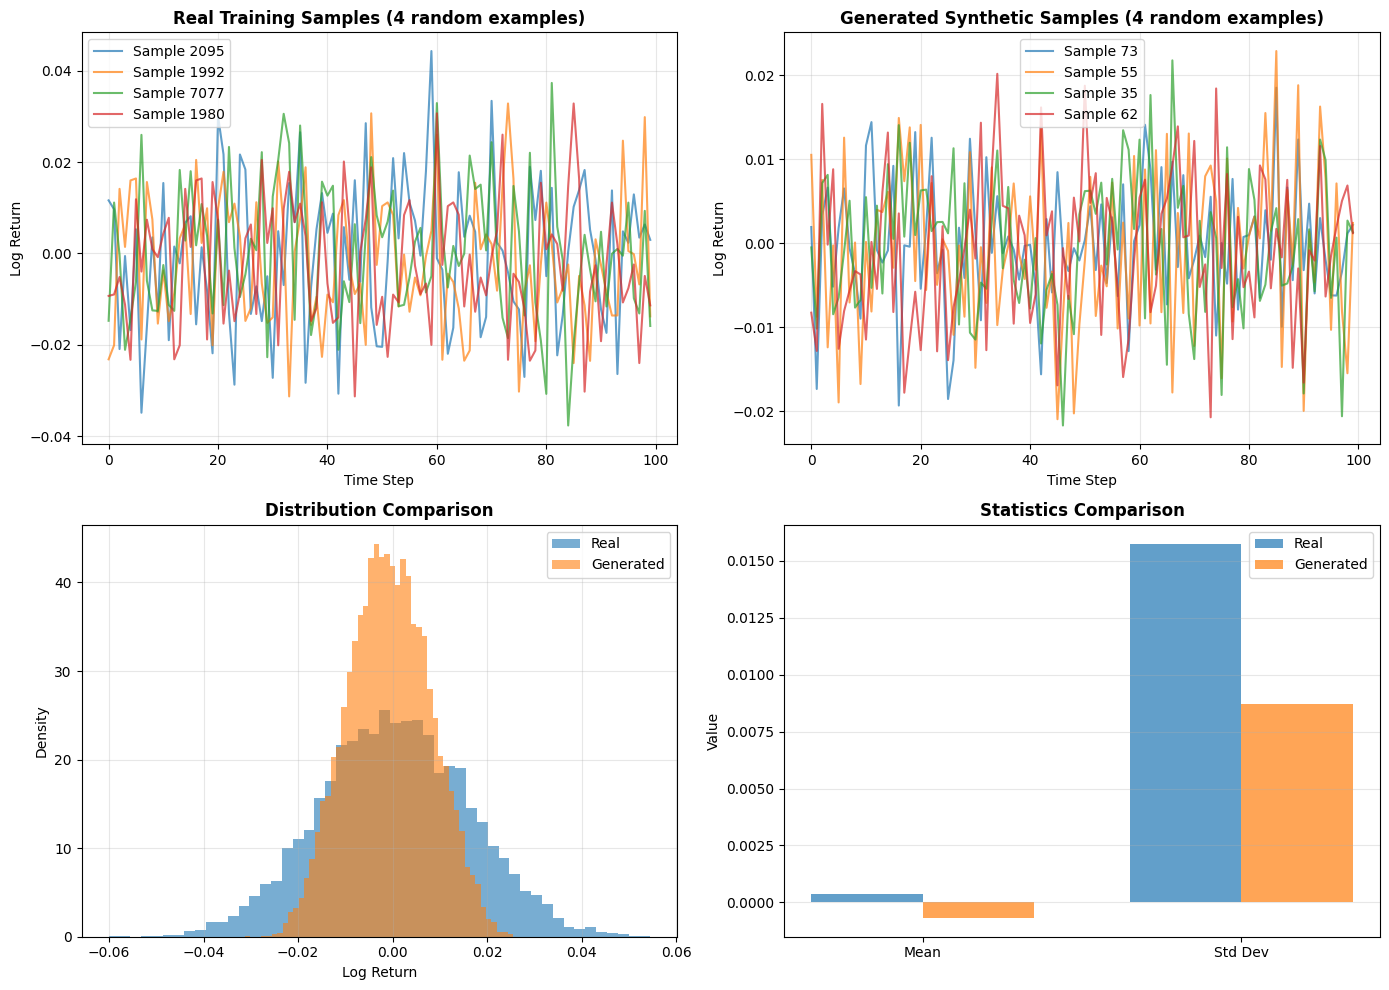


Statistics Summary:
Real data - Mean: 0.000354, Std: 0.015761
Generated - Mean: -0.000685, Std: 0.008700


In [10]:
# Visualize generated vs real samples
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

import random

# Plot 1: Real training samples (randomly select 4 unique samples)
axes[0, 0].set_title('Real Training Samples (4 random examples)', fontsize=12, fontweight='bold')
if len(train_data) > 0:
    random_real_idxs = random.sample(range(len(train_data)), min(4, len(train_data)))
    for idx, real_idx in enumerate(random_real_idxs):
        axes[0, 0].plot(train_data[real_idx].numpy(), alpha=0.7, label=f'Sample {real_idx+1}')
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Log Return')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Generated samples (randomly select 4 unique samples)
axes[0, 1].set_title('Generated Synthetic Samples (4 random examples)', fontsize=12, fontweight='bold')
if num_samples > 0:
    random_gen_idxs = random.sample(range(num_samples), min(4, num_samples))
    for idx, gen_idx in enumerate(random_gen_idxs):
        axes[0, 1].plot(generated_samples[gen_idx].numpy(), alpha=0.7, label=f'Sample {gen_idx+1}')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Log Return')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Distribution comparison
axes[1, 0].set_title('Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 0].hist(train_data.flatten().numpy(), bins=50, alpha=0.6, label='Real', density=True)
axes[1, 0].hist(generated_samples.flatten().numpy(), bins=50, alpha=0.6, label='Generated', density=True)
axes[1, 0].set_xlabel('Log Return')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Statistics comparison
axes[1, 1].set_title('Statistics Comparison', fontsize=12, fontweight='bold')
real_mean = train_data.mean().item()
real_std = train_data.std().item()
gen_mean = generated_samples.mean().item()
gen_std = generated_samples.std().item()

categories = ['Mean', 'Std Dev']
real_stats = [real_mean, real_std]
gen_stats = [gen_mean, gen_std]

x = np.arange(len(categories))
width = 0.35

axes[1, 1].bar(x - width/2, real_stats, width, label='Real', alpha=0.7)
axes[1, 1].bar(x + width/2, gen_stats, width, label='Generated', alpha=0.7)
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(categories)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nStatistics Summary:")
print(f"Real data - Mean: {real_mean:.6f}, Std: {real_std:.6f}")
print(f"Generated - Mean: {gen_mean:.6f}, Std: {gen_std:.6f}")


Using initial price: 349.13667216754004


/var/folders/5g/xd1_vnlj2zg4df463t644sgw0000gn/T/ipykernel_20449/2690129816.py:39: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


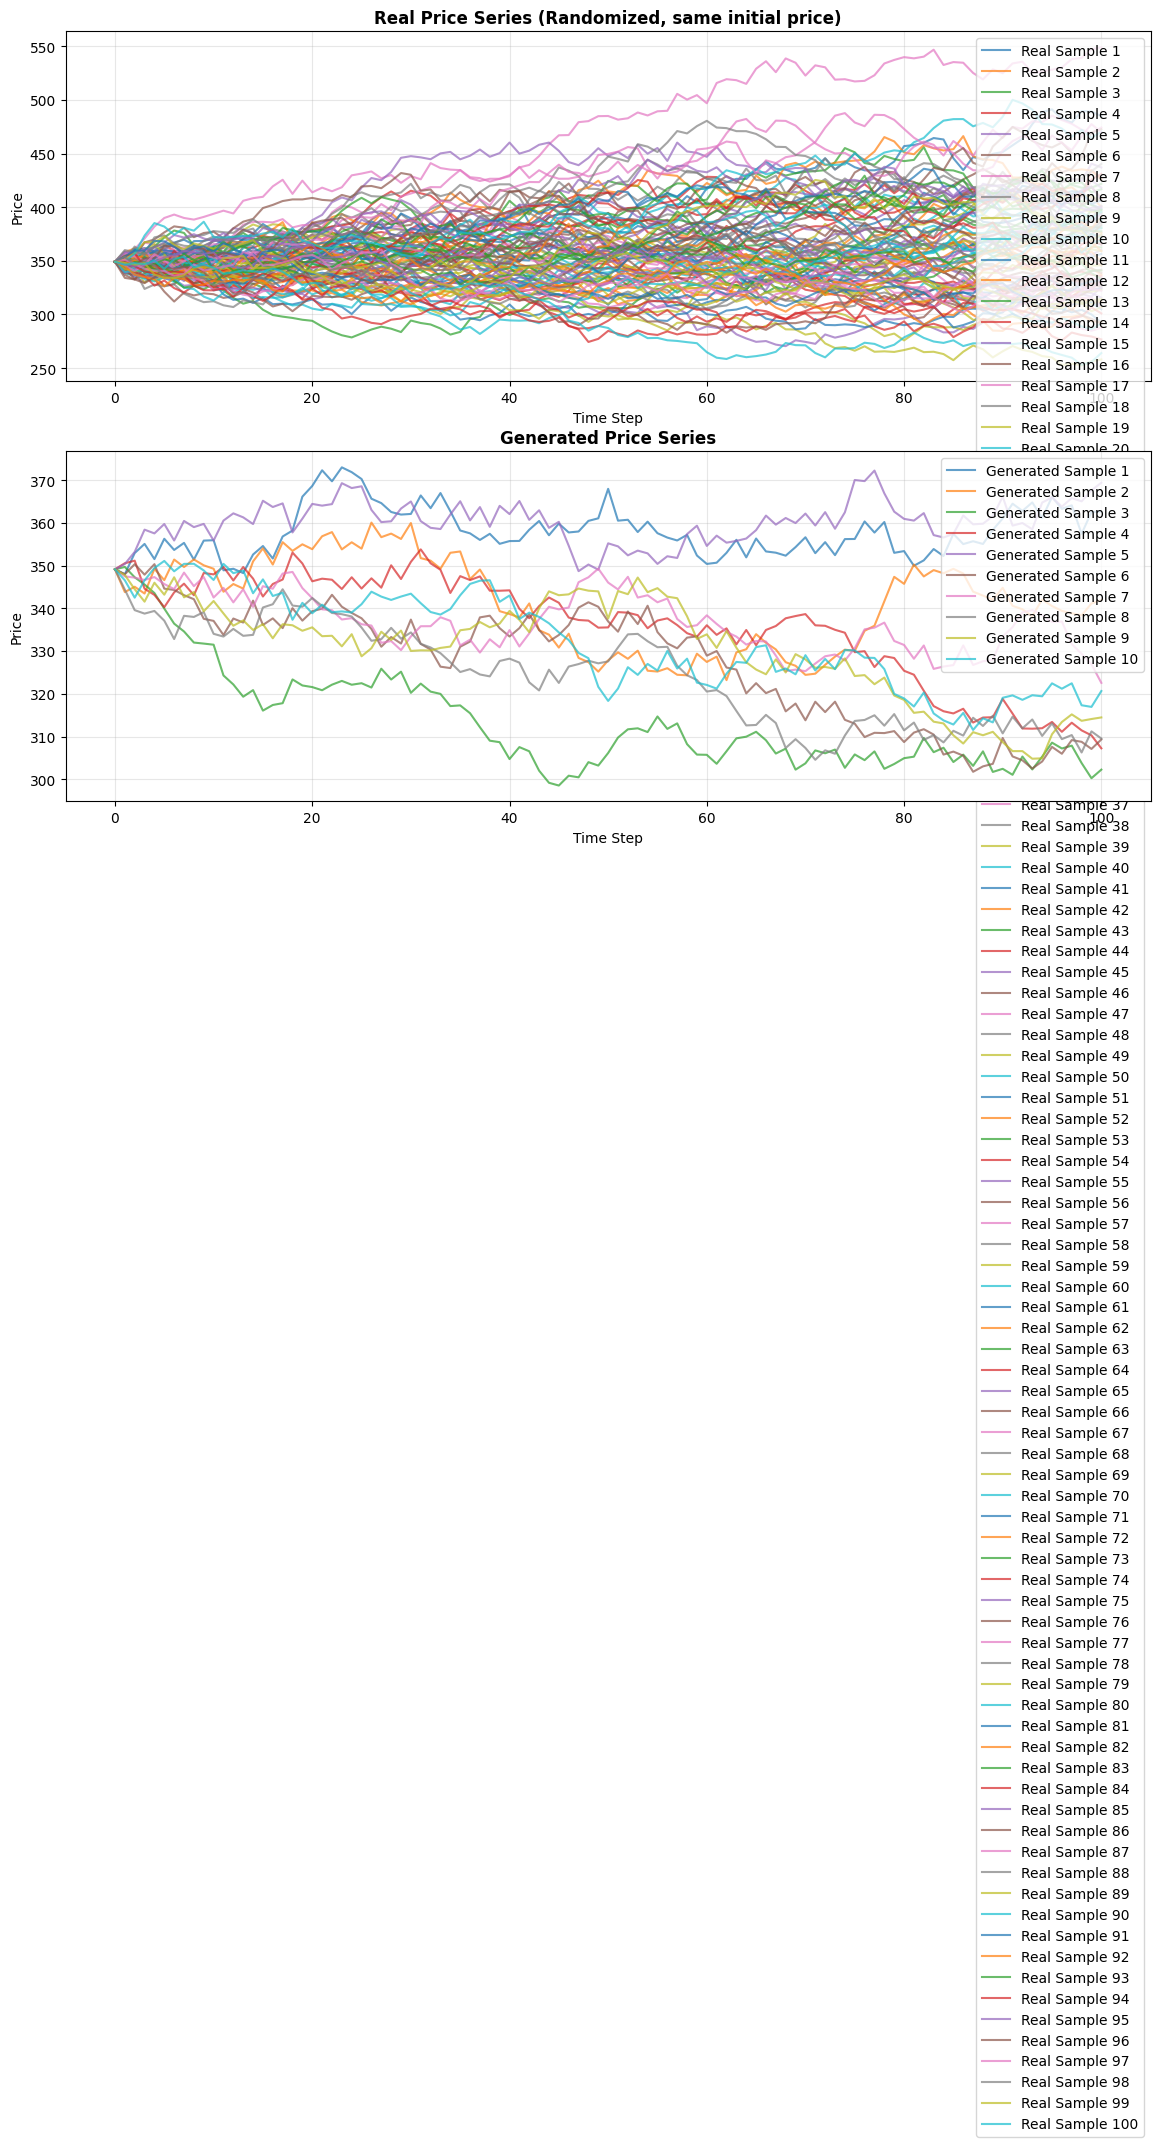


Successfully generated synthetic time series data using Takahashi Diffusion!

Note: Takahashi Diffusion uses wavelet transforms and DDPM (Denoising Diffusion
Probabilistic Model) for generating synthetic time series from log returns data.


In [ ]:
# Choose a single initial price to use for all samples
common_initial_idx = torch.randint(0, len(train_initial), (1,))
common_initial_price = train_initial[common_initial_idx].item()
print(f"Using initial price: {common_initial_price}")

# Convert generated log returns back to prices using the same initial price
generated_prices_list = []
for i in range(num_samples):
    prices = scaler.inverse_transform(generated_samples[i], torch.tensor(common_initial_price))
    generated_prices_list.append(prices)

if len(train_data) > 0:
    real_indices = torch.randperm(len(train_data))[:num_samples]
else:
    real_indices = []

# Visualize price series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Real price series (reconstructed from random training samples, using the same initial price as generated samples)
axes[0].set_title('Real Price Series (Randomized, same initial price)', fontsize=12, fontweight='bold')
for idx, i in enumerate(real_indices):
    prices = scaler.inverse_transform(train_data[i], torch.tensor(common_initial_price))
    axes[0].plot(prices.numpy(), alpha=0.7, label=f'Real Sample {idx+1}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Generated price series
axes[1].set_title('Generated Price Series', fontsize=12, fontweight='bold')
for i, prices in enumerate(generated_prices_list[:10]):  # Show first 10 to avoid clutter
    axes[1].plot(prices.numpy(), alpha=0.7, label=f'Generated Sample {i+1}')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSuccessfully generated synthetic time series data using Takahashi Diffusion!")
print("\nNote: Takahashi Diffusion uses wavelet transforms and DDPM (Denoising Diffusion")
print("Probabilistic Model) for generating synthetic time series from log returns data.")